# Packages import

## onetime installer

In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install bs4
# !pip install numpy
# !pip3 install nltk
# !pip install scipy==1.12
# !pip install gensim
# !pip install seaborn
# !pip install scikit-learn
# !pip install plotly
# !pip install sqlalchemy
# import nltk
# nltk.download('stopwords')
# !pip install requests

## import

In [2]:
#import all the necessary packages.
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import random
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
from scipy.linalg import triu
import plotly
import requests
from PIL import Image

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Data Import

In [3]:
data = pd.read_csv(r'D:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\data\fashion products small\styles-nhii.csv')
print('Number of data points : ', data.shape[0], \
      'Number of features/variables:', data.shape[1])

print(data.columns)
data.head()

Number of data points :  44446 Number of features/variables: 10
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


Dropping:
- year (unrelated to the model)

In [4]:
data.drop(['year'], axis=1, inplace=True)
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()

Number of data points :  44446 Number of features: 9


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,Puma Men Grey T-shirt


- adding image urls into the dataset

In [5]:
add_data = pd.read_csv(r'D:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\data\fashion products small\images.csv')
print(add_data.columns)

Index(['filename', 'link'], dtype='object')


In [6]:
add_data['filename'] = add_data['filename'].apply(lambda x: x.split('.')[0])
add_data.rename(columns={'filename':'id'}, inplace=True)

print(add_data.columns)

Index(['id', 'link'], dtype='object')


In [7]:
# add the link column in add_data to data
data['id'] = data['id'].astype(str)
add_data['id'] = add_data['id'].astype(str)

data = pd.merge(data, add_data, on='id')

data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,Titan Women Silver Watch,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/p...


# Data pre-processing

### Deleting null values

In [8]:
data = data.dropna()
print('Number of data points after dropping rows with any NULLs:', data.shape[0])

Number of data points after dropping rows with any NULLs: 44065


### Adding new column

In [9]:
# print all unique values of articleType in the alphabetical order
print(sorted(data['articleType'].unique()))
# print all unique values of articleType with masterCategory being apparel
apparel_article_types = sorted(data[data['masterCategory'] == 'Apparel']['articleType'].unique())
print(apparel_article_types)

['Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle', 'Basketballs', 'Bath Robe', 'Beauty Accessory', 'Belts', 'Blazers', 'Body Lotion', 'Body Wash and Scrub', 'Booties', 'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Camisoles', 'Capris', 'Caps', 'Casual Shoes', 'Churidar', 'Clothing Set', 'Clutches', 'Compact', 'Concealer', 'Cufflinks', 'Cushion Covers', 'Deodorant', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings', 'Eye Cream', 'Eyeshadow', 'Face Moisturisers', 'Face Scrub and Exfoliator', 'Face Serum and Gel', 'Face Wash and Cleanser', 'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Foundation and Primer', 'Fragrance Gift Set', 'Free Gifts', 'Gloves', 'Hair Accessory', 'Hair Colour', 'Handbags', 'Hat', 'Headband', 'Heels', 'Highlighter and Blush', 'Innerwear Vests', 'Ipad', 'Jackets', 'Jeans', 'Jeggings', 'Jewellery Set', 'Jumpsuit', 'Kajal and Eyeliner', 'Key chain', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag', 'Leggings', 'Lehenga Choli', 'Lip Care', 'Lip Gloss', 'Lip Liner'

In [10]:
def join_unique_words(row):
    product_display_name_words = set(str(row['productDisplayName']).split())
    words = set()  # A set to store unique words

    # Iterate over each column
    for col in row.index:
        if col not in ['id', 'productDisplayName', 'link', 'productDescription']:
            for word in str(row[col]).split():
                if word not in product_display_name_words:
                    words.add(word)

    return ' '.join(words)

# Apply the function to each row
data['productDescription'] = data.apply(join_unique_words, axis=1)

# Concatenate 'productDisplayName' and 'productDescription'
data['productDescription'] = data[['productDisplayName','productDescription']].astype(str).agg(' '.join, axis=1)

pd.set_option('display.max_colwidth', None)
print(data['productDescription'].head())
print(data['productDisplayName'].head())

0             Turtle Check Men Navy Blue Shirt Apparel Topwear Shirts Casual Fall
1             Peter England Men Party Blue Jeans Casual Bottomwear Summer Apparel
2                      Titan Women Silver Watch Casual Accessories Winter Watches
3    Manchester United Men Solid Black Track Pants Casual Bottomwear Apparel Fall
4                     Puma Men Grey T-shirt Apparel Topwear Summer Tshirts Casual
Name: productDescription, dtype: object
0                 Turtle Check Men Navy Blue Shirt
1               Peter England Men Party Blue Jeans
2                         Titan Women Silver Watch
3    Manchester United Men Solid Black Track Pants
4                            Puma Men Grey T-shirt
Name: productDisplayName, dtype: object


### Remove products with brief description

In [11]:
# Remove All products with very few words in title
data_sorted = data[data['productDescription'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 44065


### Removing products with dual titles per sort
1. The data is sorted based on the product description.
2. For each product, the code splits the product description into individual words.
3. The code then compares this product with the next one in the sorted list. If the number of differing words is more than 2, the products are considered different, and both are kept in the dataset. If the number of differing words is 2 or less, the products are considered the same, and the second product is removed from the dataset.
4. This process is repeated until all products have been compared.

In [12]:
print('The number of entries with duplicate title is %d'%sum(data.duplicated('productDescription')))
data_sorted.sort_values('productDescription',inplace=True, ascending=False)

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:    
    previous_i = i
    a = data['productDescription'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['productDescription'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2:
            stage1_dedupe_asins.append(data_sorted['id'].loc[indices[i]])
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['id'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

data = data.loc[data['id'].isin(stage1_dedupe_asins)]
print('Number of data points now is: ', data.shape[0])

The number of entries with duplicate title is 11193
Number of data points now is:  26810


# Text Preprocessing

In [13]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'aren', 'more', "won't", 'll', 'between', "couldn't", 've', "mustn't", 'but', 't', 'my', "you're", 'were', 'be', 'that', "don't", 'couldn', "hasn't", 'at', 'is', 'during', 'can', 'don', "weren't", 'our', 'his', 're', 'because', 'now', "you'd", 'him', 'had', 'hadn', 'won', 'if', 'itself', 'out', 'above', 'will', 'all', 'does', "you'll", 'should', "isn't", 'through', 'very', 'been', 'me', 'them', 'was', 'it', 'am', 'do', 'just', 'in', 'some', 'shan', 'each', "shouldn't", 'same', 'yourself', 'herself', 'on', 'has', 'over', 'myself', 'her', 'mustn', 'what', 'into', 'have', "wouldn't", 'himself', 'this', 'few', "it's", 'once', 's', "she's", 'isn', 'i', 'm', "aren't", "mightn't", 'y', 'no', 'of', 'nor', "that'll", 'other', 'about', "needn't", 'weren', 'again', 'd', 'ours', 'wasn', 'hers', 'too', 'wouldn', 'further', 'off', 'there', 'or', 'the', 'didn', 'she', 'yourselves', 'as', 'themselves', 'your', 'he', 'both', 'those', 'then', 'here', 'own', 'an', 'are', 'who', "wasn

In [14]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [15]:
data["baseColour"] = data["baseColour"].str.lower()

In [16]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,Turtle Check Men Navy Blue Shirt Apparel Topwear Shirts Casual Fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,Peter England Men Party Blue Jeans Casual Bottomwear Summer Apparel
3,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,Manchester United Men Solid Black Track Pants Casual Bottomwear Apparel Fall
5,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,Inkfruit Mens Chain Reaction T-shirt Grey Apparel Men Topwear Summer Tshirts Casual
7,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,Jealous 21 Women Purple Shirt Apparel Topwear Summer Shirts Casual


In [17]:
unique = data['gender'].unique()
print(unique)
unique = data['masterCategory'].unique()
print(unique)
unique = data['subCategory'].unique()
print(unique)
unique = data['articleType'].unique()
print(unique)
unique = data['baseColour'].unique()
print(unique)

['Men' 'Women' 'Boys' 'Unisex' 'Girls']
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
['Topwear' 'Bottomwear' 'Watches' 'Shoes' 'Belts' 'Flip Flops' 'Innerwear'
 'Sandal' 'Shoe Accessories' 'Jewellery' 'Lips' 'Bags' 'Saree' 'Fragrance'
 'Scarves' 'Dress' 'Loungewear and Nightwear' 'Wallets' 'Apparel Set'
 'Eyewear' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup' 'Free Gifts' 'Socks'
 'Accessories' 'Nails' 'Beauty Accessories' 'Ties' 'Water Bottle' 'Skin'
 'Bath and Body' 'Gloves' 'Sports Accessories' 'Cufflinks'
 'Sports Equipment' 'Hair' 'Stoles' 'Perfumes' 'Home Furnishing'
 'Umbrellas' 'Wristbands' 'Vouchers']
['Shirts' 'Jeans' 'Track Pants' 'Tshirts' 'Watches' 'Casual Shoes' 'Belts'
 'Flip Flops' 'Bra' 'Sandals' 'Shoe Accessories' 'Sweatshirts'
 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats' 'Handbags' 'Waistcoat'
 'Sports Shoes' 'Shorts' 'Briefs' 'Kurtas' 'Sarees'
 'Perfume and Body Mist' 'Heels' 'Tops' 'Laptop Bag' 'Scarves' 'Dresses'
 'Night

In [18]:
# print all unique values of articleType with the masterCategory 'Apparel'
print(sorted(data[data['masterCategory']=='Apparel']['articleType'].unique()))

['Baby Dolls', 'Bath Robe', 'Belts', 'Blazers', 'Booties', 'Boxers', 'Bra', 'Briefs', 'Camisoles', 'Capris', 'Churidar', 'Clothing Set', 'Dresses', 'Dupatta', 'Innerwear Vests', 'Jackets', 'Jeans', 'Jeggings', 'Jumpsuit', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Leggings', 'Lehenga Choli', 'Lounge Pants', 'Lounge Shorts', 'Lounge Tshirts', 'Nehru Jackets', 'Night suits', 'Nightdress', 'Patiala', 'Rain Jacket', 'Robe', 'Rompers', 'Salwar', 'Salwar and Dupatta', 'Sarees', 'Shapewear', 'Shirts', 'Shorts', 'Shrug', 'Skirts', 'Stockings', 'Suits', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Swimwear', 'Tights', 'Tops', 'Track Pants', 'Tracksuits', 'Trousers', 'Trunk', 'Tshirts', 'Tunics', 'Waistcoat']


# print all unique values of articleType with the 

In [19]:
start_time = time.time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['productDescription'], index, 'productDescription')
# we print the time it took to preprocess whole titles 
print(time.time() - start_time, "seconds")

data.head()

42.154438495635986 seconds


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
3,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
5,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
7,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual


In [20]:
data.reset_index(inplace=True)

In [22]:
data.drop("index",axis=1,inplace=True)

In [23]:
data['baseColour'] = data['baseColour'].astype(str)

In [24]:
def convrt_remove_dup(x):
    x =x.split(",")
    x = list(dict.fromkeys(x))
    x = ",".join(x)
    return x

In [25]:
data["baseColour"] = data["baseColour"].apply(lambda x: convrt_remove_dup(x))

In [26]:
data['baseColour'] = data['baseColour'].astype(str)

In [27]:
len(data["baseColour"].unique())

46

In [28]:
pd.set_option("display.max_colwidth", None)

In [29]:
data.index[data['id'] == '48123'].tolist()

[7]

In [30]:
data["link"].describe()

count         26666
unique        26660
top       undefined
freq              5
Name: link, dtype: object

In [31]:
# drop all undefined links
data = data[data['link'] != 'undefined']
data["link"].describe()

count                                                                                                   26661
unique                                                                                                  26659
top       http://assets.myntassets.com/v1/images/style/properties/f064e90e3d026a23298593e2607d93cf_images.jpg
freq                                                                                                        2
Name: link, dtype: object

In [32]:
# drop duplicate links
data = data.drop_duplicates(subset='link', keep='first')

In [33]:
data.describe()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
count,26659,26659,26659,26659,26659,26659,26659,26659,26659,26659,26659
unique,26659,5,7,44,140,46,4,8,25788,26659,26535
top,15970,Men,Apparel,Topwear,Tshirts,black,Summer,Casual,Portia Women Maroon Flats,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,paris hilton women perfume care fragrance spring mist body personal casual pink
freq,1,13352,13380,9477,4726,5034,13049,20612,6,1,3


In [34]:
data.reset_index(inplace=True)

In [35]:
data.drop("index",axis=1,inplace=True)
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
3,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
4,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual
...,...,...,...,...,...,...,...,...,...,...,...
26654,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher blush care highlighter spring personal casual pink makeup women
26655,17036,Men,Footwear,Shoes,Casual Shoes,white,Summer,Casual,Gas Men Caddy Casual Shoe,http://assets.myntassets.com/v1/images/style/properties/b947795554076c9826e050cf80136198_images.jpg,gas men caddy casual shoe summer shoes footwear white
26656,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop flops red footwear summer men casual
26657,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt apparel fall topwear casual tshirts


In [36]:
import os
import pandas as pd

cwd = os.getcwd()
print(cwd)
file_path = cwd + "\\clothingdata_final.csv"

data.to_csv(file_path)

d:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\notebooks


In [37]:
df = pd.read_csv(file_path)
df

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
2,2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
3,3,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
4,4,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual
...,...,...,...,...,...,...,...,...,...,...,...,...
26654,26654,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher blush care highlighter spring personal casual pink makeup women
26655,26655,17036,Men,Footwear,Shoes,Casual Shoes,white,Summer,Casual,Gas Men Caddy Casual Shoe,http://assets.myntassets.com/v1/images/style/properties/b947795554076c9826e050cf80136198_images.jpg,gas men caddy casual shoe summer shoes footwear white
26656,26656,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop flops red footwear summer men casual
26657,26657,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt apparel fall topwear casual tshirts


In [38]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26659 entries, 0 to 26658
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  26659 non-null  int64 
 1   gender              26659 non-null  object
 2   masterCategory      26659 non-null  object
 3   subCategory         26659 non-null  object
 4   articleType         26659 non-null  object
 5   baseColour          26659 non-null  object
 6   season              26659 non-null  object
 7   usage               26659 non-null  object
 8   productDisplayName  26659 non-null  object
 9   link                26659 non-null  object
 10  productDescription  26659 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.2+ MB


In [39]:
df.reset_index(inplace=True)

In [40]:
df.drop('index',axis=1,inplace=True)

In [41]:
df.rename(columns={"level_0": "id"},inplace=True)
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
3,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
4,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual
...,...,...,...,...,...,...,...,...,...,...,...
26654,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher blush care highlighter spring personal casual pink makeup women
26655,17036,Men,Footwear,Shoes,Casual Shoes,white,Summer,Casual,Gas Men Caddy Casual Shoe,http://assets.myntassets.com/v1/images/style/properties/b947795554076c9826e050cf80136198_images.jpg,gas men caddy casual shoe summer shoes footwear white
26656,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop flops red footwear summer men casual
26657,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt apparel fall topwear casual tshirts


DATA Connection

In [42]:
import sqlite3
conn = sqlite3.connect('clothing_db.sqlite3')
c = conn.cursor()

# list all columns of df
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'productDisplayName', 'link',
       'productDescription'],
      dtype='object')


In [43]:
c.execute('CREATE TABLE IF NOT EXISTS store_product (id integer, gender text, masterCategory text, subCategory text, articleType text, baseColour text, season text, usage text, productDisplayName text, link text, productDescription text)')

conn.commit()
df.to_sql('store_product', conn, if_exists='replace', index = False)
conn.close()
df.to_csv("clothingdata_finalx.csv")

DATA EXTRACT

In [44]:
from sqlalchemy import create_engine

cnx = create_engine('sqlite:///clothing_db.sqlite3').connect()

dataframe_store_product = pd.read_sql_table('store_product', cnx)
dataframe_store_product

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
3,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
4,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual
...,...,...,...,...,...,...,...,...,...,...,...
26654,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher blush care highlighter spring personal casual pink makeup women
26655,17036,Men,Footwear,Shoes,Casual Shoes,white,Summer,Casual,Gas Men Caddy Casual Shoe,http://assets.myntassets.com/v1/images/style/properties/b947795554076c9826e050cf80136198_images.jpg,gas men caddy casual shoe summer shoes footwear white
26656,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop flops red footwear summer men casual
26657,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt apparel fall topwear casual tshirts


In [45]:
# Utility Functions
# Display an image
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

def plot_heatmap(keys, values, labels, url, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys)
        ax.set_title(text)
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        display_img(url, ax, fig)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
stemmer = SnowballStemmer("english")

In [47]:
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = ' '.join([stemmer.stem(item) for item in tokens])    #Stemming each token
    return cleaned_article

In [48]:
import gensim.downloader

In [49]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [50]:
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt apparel shirts fall topwear casual
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans apparel bottomwear summer casual
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants fall apparel bottomwear casual
3,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt apparel grey topwear men summer tshirts casual
4,26960,Women,Apparel,Topwear,Shirts,purple,Summer,Casual,Jealous 21 Women Purple Shirt,http://assets.myntassets.com/v1/images/style/properties/45ddbc6a15140556214e15923244755b_images.jpg,jealous 21 women purple shirt apparel shirts topwear summer casual
...,...,...,...,...,...,...,...,...,...,...,...
26654,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher blush care highlighter spring personal casual pink makeup women
26655,17036,Men,Footwear,Shoes,Casual Shoes,white,Summer,Casual,Gas Men Caddy Casual Shoe,http://assets.myntassets.com/v1/images/style/properties/b947795554076c9826e050cf80136198_images.jpg,gas men caddy casual shoe summer shoes footwear white
26656,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop flops red footwear summer men casual
26657,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt apparel fall topwear casual tshirts


<h3> GLOBAL Model returing only ASIN"s </h3>

In [51]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['productDescription'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['productDescription'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

idf_euclidean=[]
def idf_model(doc_id, num_results):
    M=[]
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):

        M.append(data['id'].loc[df_indices[i]])

    return M

tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):

    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['id'].loc[df_indices[i]])
    return L

title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['productDescription'])
title_features.get_shape()
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):

    B=[]
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):

        B.append(data['id'].loc[df_indices[i]])

    return B

def global_model(doc_id,num_results):
    G= bag_of_words_model(doc_id,num_results) + tfidf_model(doc_id,num_results) + idf_model(doc_id,num_results)
    G = list(dict.fromkeys(G))
    return G
    

## 1.Bag of Words model on Product Titles and color

In [52]:
title_vectorizer = CountVectorizer()
color_features   = title_vectorizer.fit_transform(df['baseColour'])
title_features   = title_vectorizer.fit_transform(df['productDescription'])

title_features.get_shape()
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id]) + pairwise_distances(color_features,color_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(df.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],df['productDescription'].loc[df_indices[0]], df['productDescription'].loc[df_indices[i]], df['link'].loc[df_indices[i]], 'bag_of_words')
        print('ID :',df['id'].loc[df_indices[i]])
        print ('Title:', df['productDescription'].loc[df_indices[i]])
        bag_of_words_euclidean.append(pdists[i])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    print('Average euclidean distance is ',sum(bag_of_words_euclidean)/num_results)

Getting the similar items for document id and number of items


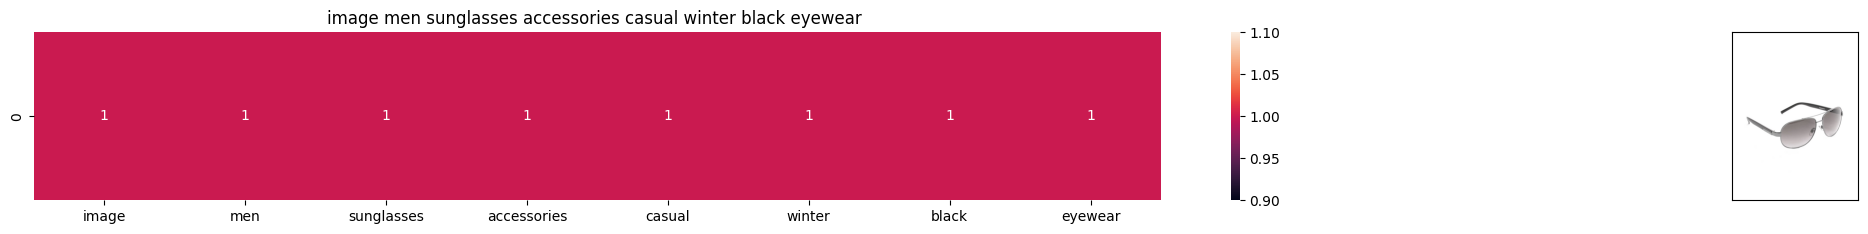

ID : 16957
Title: image men sunglasses accessories casual winter black eyewear 
Euclidean similarity with the query image : 0.0


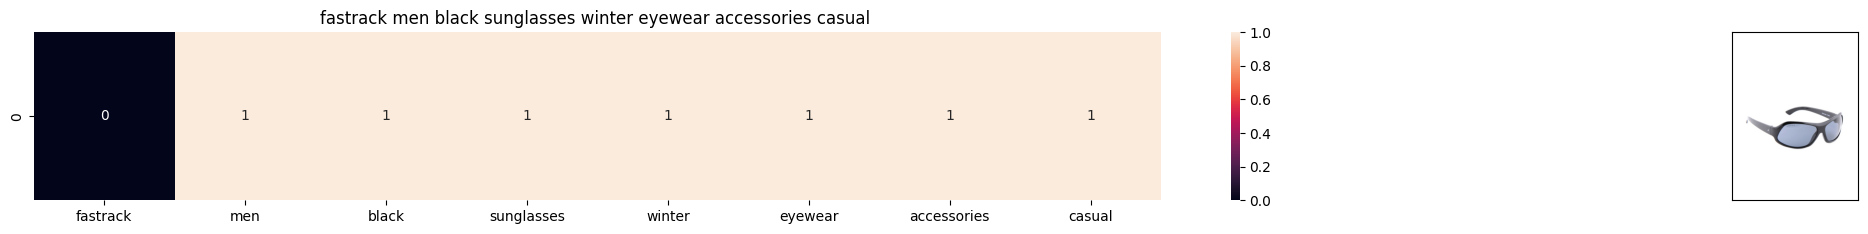

ID : 28285
Title: fastrack men black sunglasses winter eyewear accessories casual 
Euclidean similarity with the query image : 1.4142135623730951


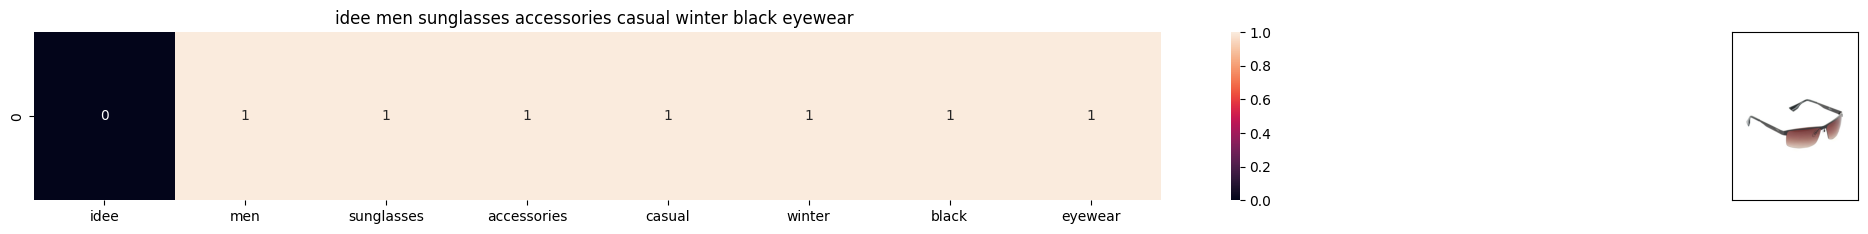

ID : 28344
Title: idee men sunglasses accessories casual winter black eyewear 
Euclidean similarity with the query image : 1.4142135623730951


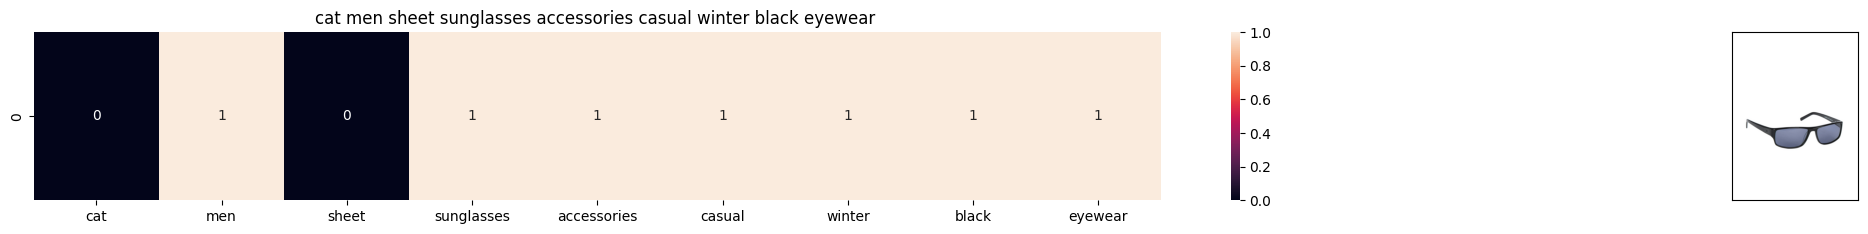

ID : 29962
Title: cat men sheet sunglasses accessories casual winter black eyewear 
Euclidean similarity with the query image : 1.7320508075688772


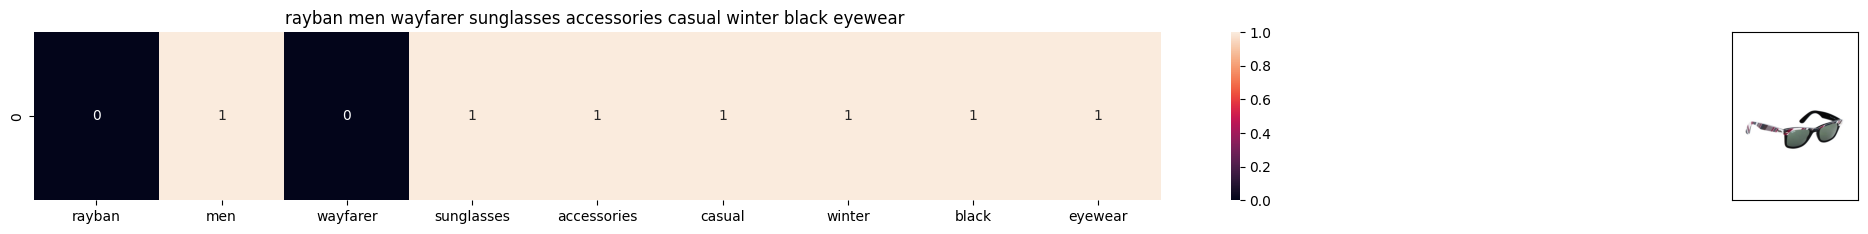

ID : 23711
Title: rayban men wayfarer sunglasses accessories casual winter black eyewear 
Euclidean similarity with the query image : 1.7320508075688772


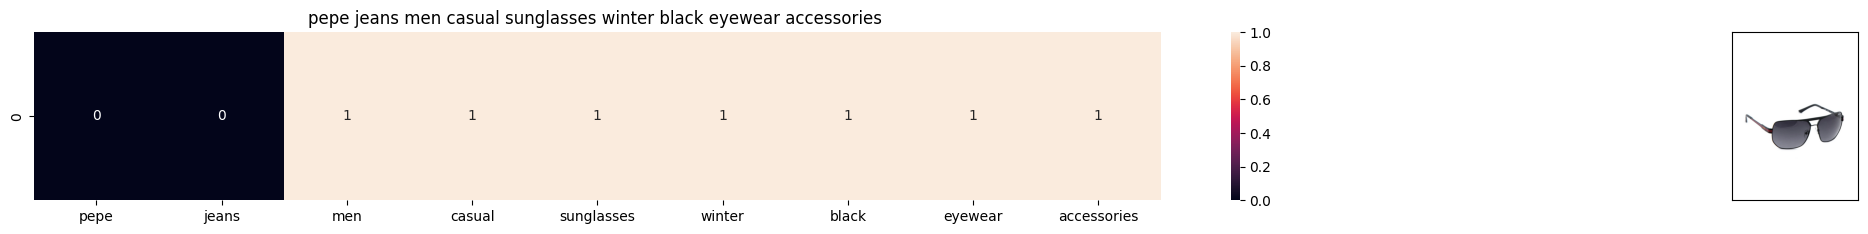

ID : 17333
Title: pepe jeans men casual sunglasses winter black eyewear accessories 
Euclidean similarity with the query image : 1.7320508075688772
Average euclidean distance is  1.3374299245754704


In [53]:
print('Getting the similar items for document id and number of items')
bag_of_words_model(56, 6)

## 2.TF-IDF BASED PRODUCT SIMILARITY

In [54]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['id'].loc[df_indices[i]])
    return L

In [55]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['productDescription'].loc[df_indices[0]], data['productDescription'].loc[df_indices[i]],data['link'].loc[df_indices[i]], 'tfidf')
        print('ID :',data['id'].loc[df_indices[i]])
        tf_idf_euclidean.append(pdists[i])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is',sum(tf_idf_euclidean)/num_results)

## 3. IDF BASED PRODUCT SIMILARITY

In [56]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['productDescription'])

In [57]:
def n_containing(word):
    return sum(1 for blob in data['productDescription'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0] / (n_containing(word)))

In [58]:
idf_euclidean=[]
def idf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['productDescription'].loc[df_indices[0]], data['productDescription'].loc[df_indices[i]], data['link'].loc[df_indices[i]], 'idf')
        print('ID :',data['id'].loc[df_indices[i]])
        idf_euclidean.append(pdists[i])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is ',sum(idf_euclidean)/num_results)

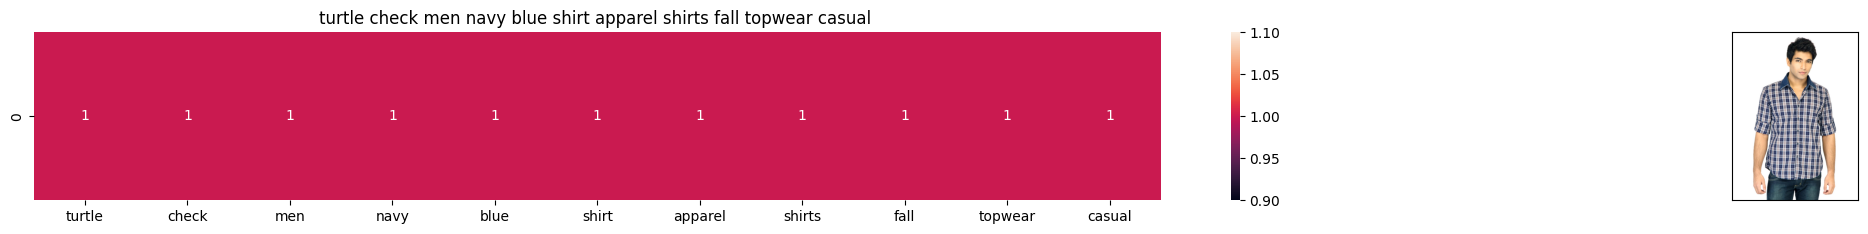

ID : 15970
euclidean distance from the given image : 0.0


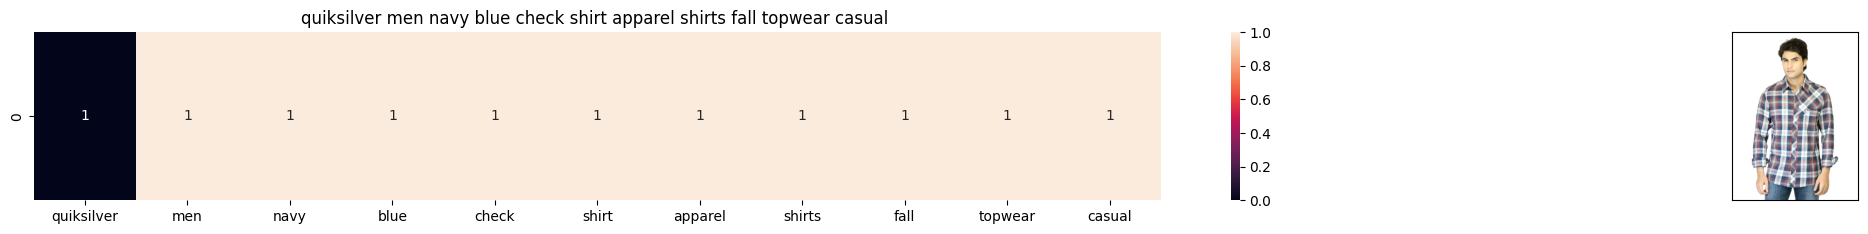

ID : 19465
euclidean distance from the given image : 1.4142135623730951


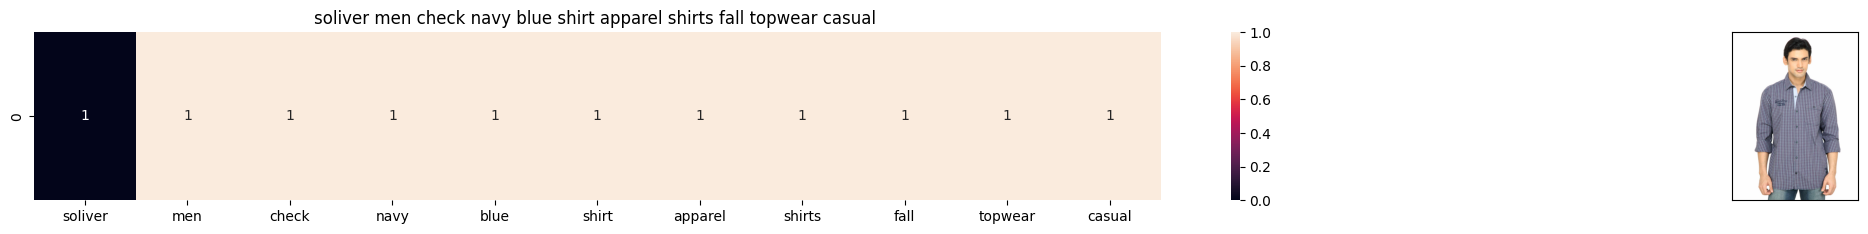

ID : 21121
euclidean distance from the given image : 1.4142135623730951


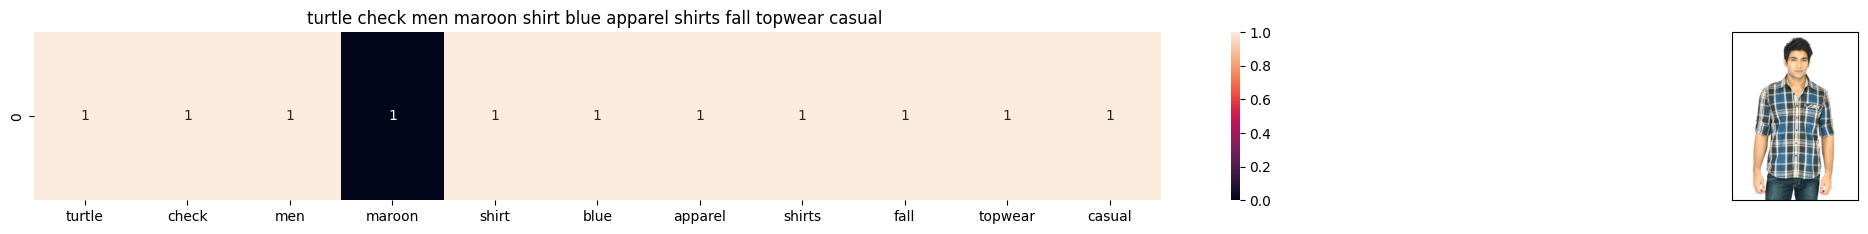

ID : 15972
euclidean distance from the given image : 1.4142135623730951


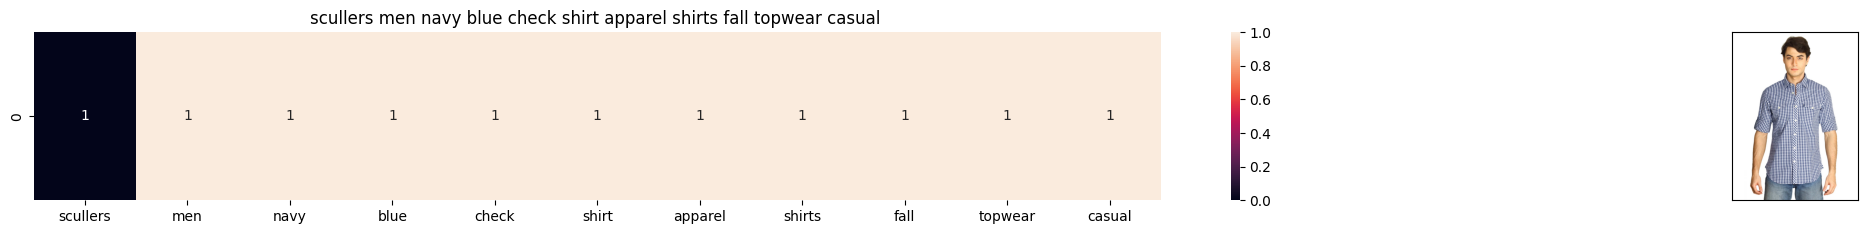

ID : 7172
euclidean distance from the given image : 1.4142135623730951
Average euclidean distance is  1.131370849898476


In [59]:
idf_model(0,5)

## 4. KNN BASED PRODUCT SIMILARITY

In [60]:
import numpy as np
import pandas as pd 
from sklearn.neighbors import NearestNeighbors

In [61]:
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'productDisplayName', 'link',
       'productDescription'],
      dtype='object')

In [62]:
sparse_matrix_products = df[['masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']]

In [63]:
sparse_matrix_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26659 entries, 0 to 26658
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   masterCategory  26659 non-null  object
 1   subCategory     26659 non-null  object
 2   articleType     26659 non-null  object
 3   baseColour      26659 non-null  object
 4   season          26659 non-null  object
 5   usage           26659 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [64]:
sparse_matrix_products = pd.get_dummies(sparse_matrix_products)

In [65]:
model = NearestNeighbors(n_neighbors=15,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
model.fit(sparse_matrix_products)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [66]:
import pickle

# Assuming 'model' is your KNN model
with open('clothing_knn.pkl', 'wb') as f:
    pickle.dump(model, f)

In [68]:
# load the model from disk
with open('clothing_knn.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

query_index = 0  # Replace 0 with the desired index value
distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index, :].values.reshape(1, -1))

query_index = 58

distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index, :].values.reshape(1, -1))

print(len(distances.flatten()))
M=[]
D=[]
for i in range(0,10):
    if i==0:
        print("Recommendation for {0}:\n".format(sparse_matrix_products.index[query_index]))
    else:
        M.append(sparse_matrix_products.index[indices.flatten()[i]])
        D.append(distances.flatten()[i])
        print("{0}: {1}, with distance of {2}".format(i,sparse_matrix_products.index[indices.flatten()[i]],distances.flatten()[i]))

15
Recommendation for 58:

1: 16662, with distance of 0.0
2: 24629, with distance of 0.0
3: 4081, with distance of 0.0
4: 3045, with distance of 0.0
5: 702, with distance of 0.0
6: 5160, with distance of 0.0
7: 24837, with distance of 0.0
8: 10616, with distance of 0.0
9: 21499, with distance of 0.0


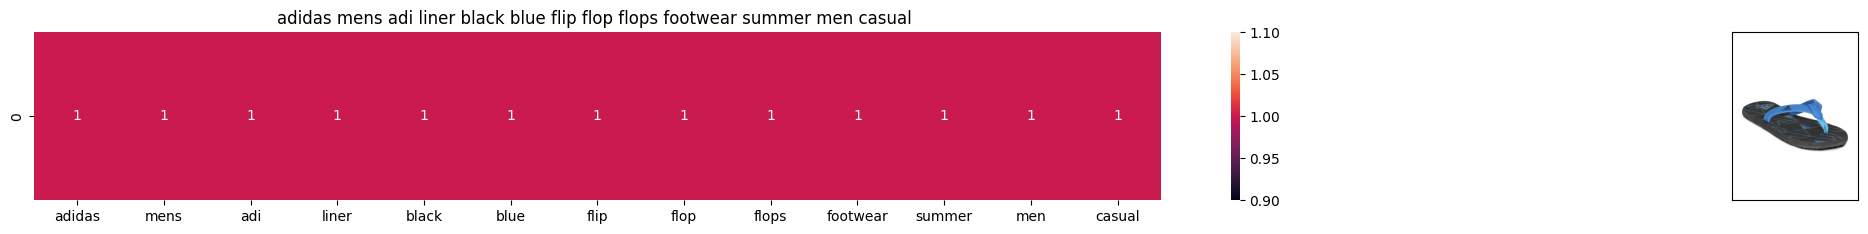

ID : 5635
Color: black
Title: adidas mens adi liner black blue flip flop flops footwear summer men casual 
The distance is:  0.0


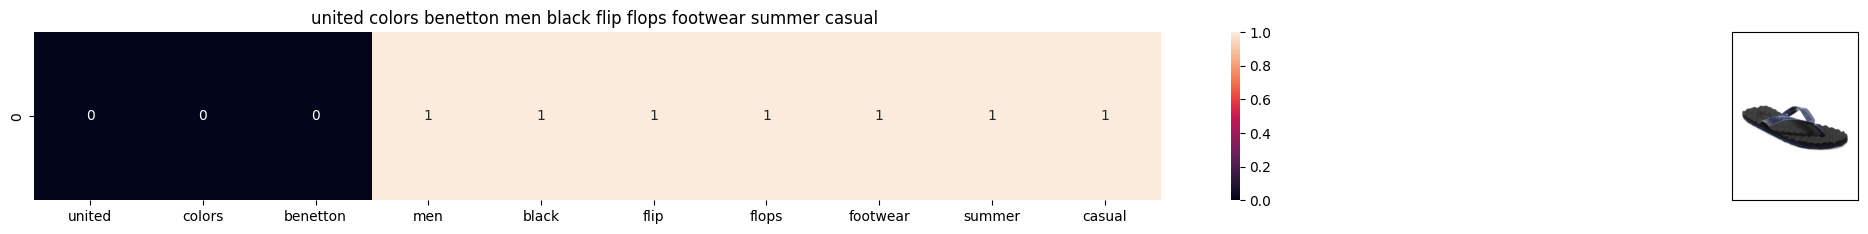

ID : 56858
Color: black
Title: united colors benetton men black flip flops footwear summer casual 
The distance is:  0.0


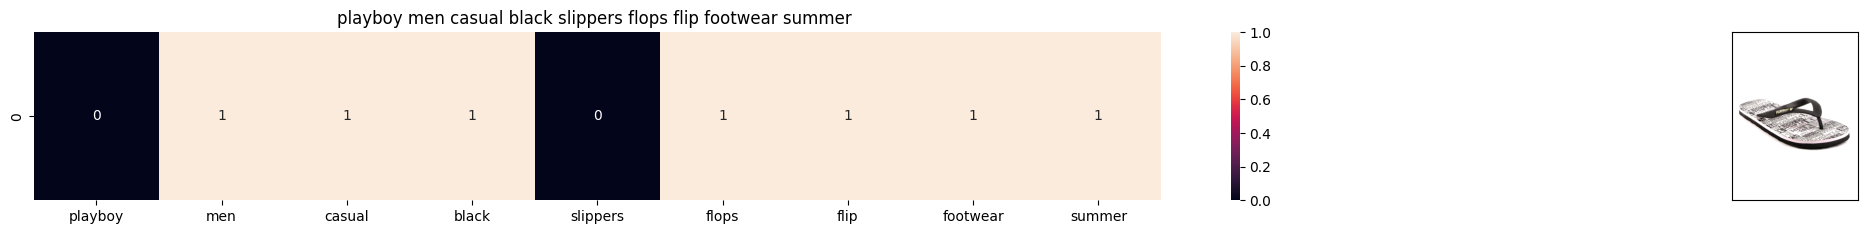

ID : 11858
Color: black
Title: playboy men casual black slippers flops flip footwear summer 
The distance is:  0.0


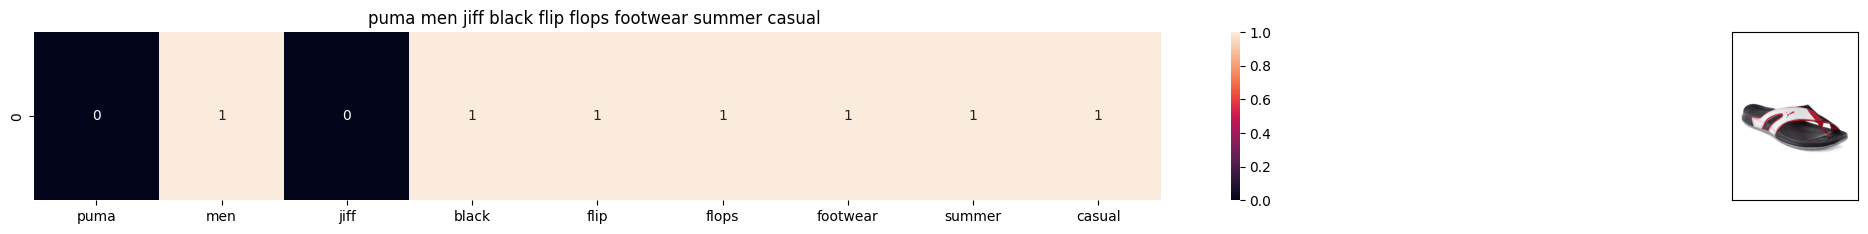

ID : 23812
Color: black
Title: puma men jiff black flip flops footwear summer casual 
The distance is:  0.0


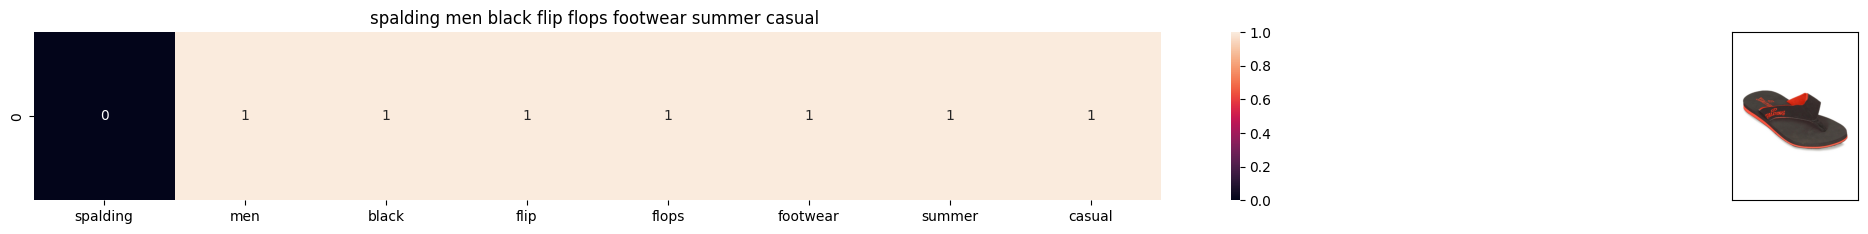

ID : 3996
Color: black
Title: spalding men black flip flops footwear summer casual 
The distance is:  0.0


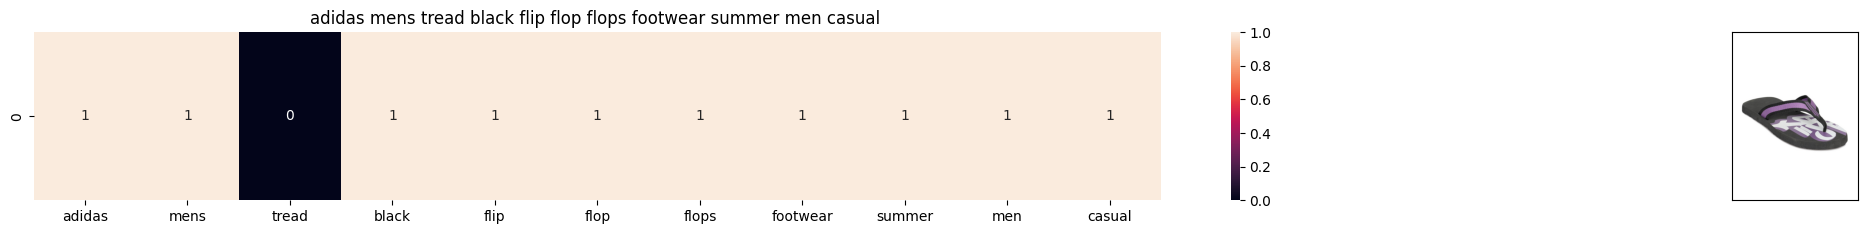

ID : 6167
Color: black
Title: adidas mens tread black flip flop flops footwear summer men casual 
The distance is:  0.0


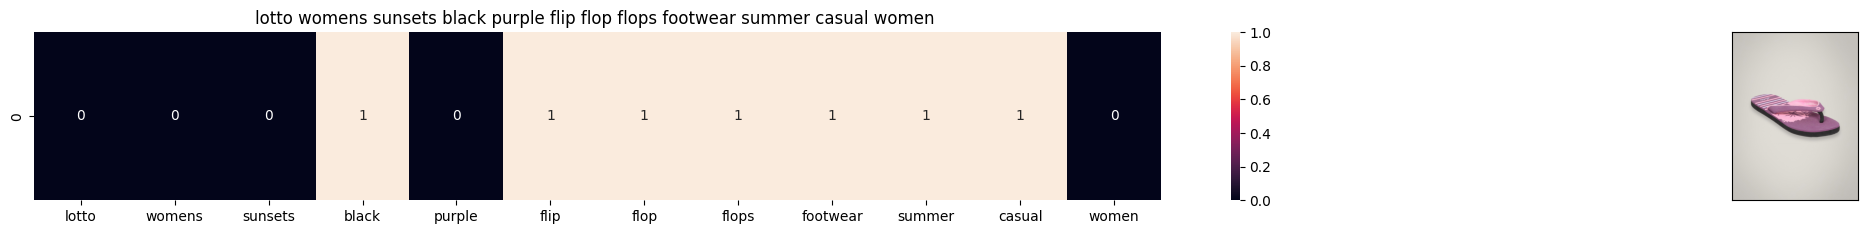

ID : 6451
Color: black
Title: lotto womens sunsets black purple flip flop flops footwear summer casual women 
The distance is:  0.0


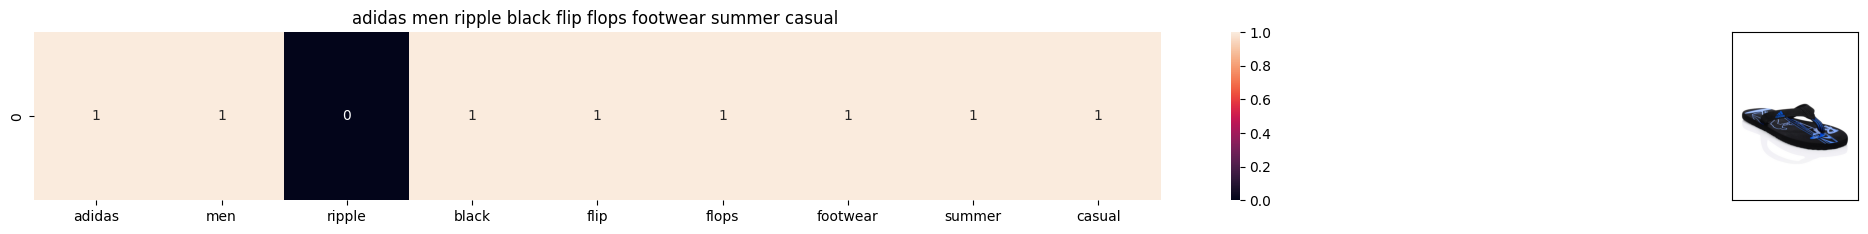

ID : 32183
Color: black
Title: adidas men ripple black flip flops footwear summer casual 
The distance is:  0.0


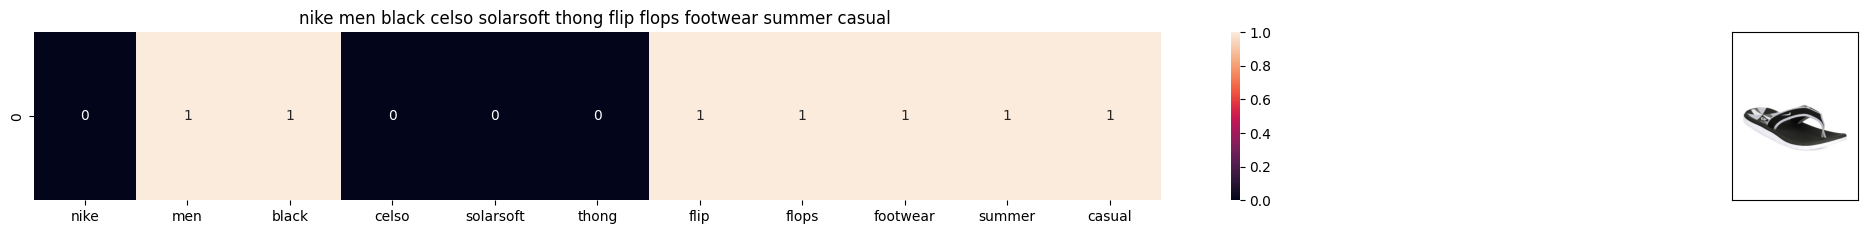

ID : 42127
Color: black
Title: nike men black celso solarsoft thong flip flops footwear summer casual 
The distance is:  0.0


In [69]:
for i in range(0,len(M)):
    get_result(M[i],df['productDescription'].loc[M[0]], df['productDescription'].loc[M[i]], df['link'].loc[M[i]], 'bag_of_words')
    print('ID :',df['id'].loc[M[i]])
    print ('Color:', df['baseColour'].loc[M[i]])
    print ('Title:', df['productDescription'].loc[M[i]])
    print ("The distance is: ", D[i])
    print('='*60)

### Comparing the models

In [70]:
euclidean_distance=[]
num_results=20
euclidean_distance.append(sum(bag_of_words_euclidean)/num_results)
euclidean_distance.append(sum(tf_idf_euclidean)/num_results)
euclidean_distance.append(sum(idf_euclidean)/num_results)
x=euclidean_distance
y=[]
for i in range(0,47,3):
    y.append(i)

euclidean_distance

[0.40122897737264107, 0.0, 0.282842712474619]

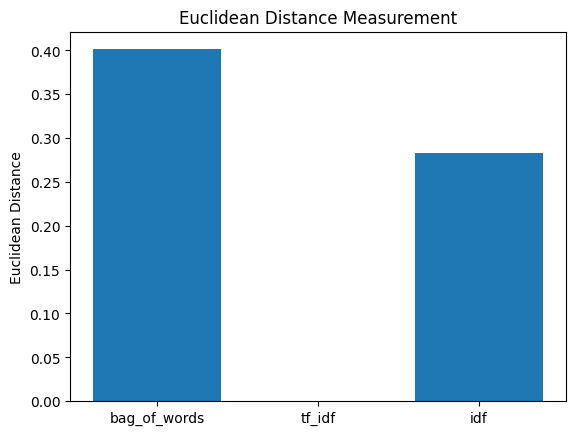

In [71]:
import matplotlib.pyplot as plt
import numpy as np

objects = ('bag_of_words', 'tf_idf', 'idf')
y_pos = np.arange(len(objects))
plt.bar(objects, x)
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Measurement')
plt.savefig('Comparison between clothing models.png')
plt.show()